# Topic Detection with Latent Dirichlet Allocation

## Introduction
This tutorial explores the topic of latent Dirichlet Allocation (LDA), and how it can be used for topic detection. Topic modeling is an area of natural language processing to discover structure about text in docuemnts. Latent Dirichlet Allocation is one algorithm to achieve this, which is a type of generative statistical model. The name itself explains how it works - it allocates topics over a Dirichlet distribution with latent or hidden probabilities on unobserved groups. To simplify greatly the basic concept of LDA a corpus is made of documents that are a random mix of K topics, and each topic is a distribution of terms from the corpus. Each term is thought to belong to each topic with some probability, and topics are then inferred from the terms that comprise it with the greatest probability.

The benefit to using latent dirichlet you don't have to know the topics beforehand and can discover themes within a text. That being said, you do have to choose the value k of topics and have to infer the actual topic. LDA is still a useful tool for not only text but can also be used for images and music. For purpose of this tutorial we will focus on text. An application of LDA is to understand what a collection of documents is about. The collection of documents could be anything from new stories to emails to social media posts, where you want to discover what people are talking about. This could be useful to show a trending topics feature for instance or learning topics to apply tags to new documents. We will apply LDA to some real examples, but first understand how the topics are generated and in order to interpret correctly. Then we will look at some different tactics improve topic dectection.

## Tutorial content

This tutorial will show you how to implement LDA and how to do some basic topic detection. We will first look at the math understand how the algorithm works. We will also look at existing python libraries, specifically GENSIM to leverage different options for parameters. We will also make use of nltk librabry for natural language processing and string, numpy, matplotlib for processing data. Additionally a script I wrote for another homework will be used to get data from yelp.

We'll be using data from 2 sources to see how topic detection may differ including web scraping from yelp reviews:

    https://www.yelp.com/biz/primanti-bros-pittsburgh-15?osq=Primanti+Bros.
    https://www.yelp.com/search?find_desc=Bottega+Louie&find_loc=Los+Angeles,+CA

The following topics are covered in this tutorial:
    Installing the libraries    
    Understanding the model
    Loading data
    Corpus pre-processing
    Using LDA for topic detection on loaded data
    Text representation choices to improve topic detection
    Choosing K number of topics
    Putting it together: Yelp review topic detection example


## Installing the libraries

The libraries in the following code are needed for the tutorial. For packages not already installed please run with the following command where package name would replace gensim. For NLTK ensure when downloading to choose maxent_treebank_pos_

$ pip install gemsim --upgrade

You will also need to install pattern-2.6 for gensim though not explicitly imported
$ pip install pattern

In [271]:
import string
import nltk
import gensim
import numpy as np
from collections import Counter
#to plot
import matplotlib
import matplotlib.pyplot as plt
import scraper

## Understanding the model

The math behind LDA may seem a bit convoluted at first glance, but the basic components are Bayesian statistics with a dirichlet distribution. It was mentioned that LDA treats the documents as a mix of topics, which are a mix of words. The assumptions are that words are indepedent i.e. bag of words. Each document can then be thought of as randomly sampled from a distribution of topics, and each topic is a random sample from a distribution of words. While documents are not actually constructed this way, this allows unknown priors to be estimated with bayesian statistics. Since the documents are a distribution of a distribution, dirichlet is used for the prior. Dirichlet is a multivariate distribution that makes it suitable for LDA. You can find more information on the distribution on wikipedia https://en.wikipedia.org/wiki/Dirichlet_distribution. The prior cannot be calculated directly but estimated by maximizing the log likelihood. There are several choices how to estimate this including bayesian variance, Gibb's sampling, and Newton’s method. The references include further reading regarding different choices for estimation.

## Loading Data

To begin exploring LDA we will explore some restaurant reviews from Yelp in the Pittsburgh area to compare the topics output using LDA. The below function will take scrape all reviews from yelp for a given url.

In [269]:
"""
Returns data and header for a given url for yelp
"""
def load_yelp(url, header = True):
    #using scraper function from homework 2, get yelp reviews
    data = scraper.extract_reviews(url)
    header = data[0].keys()
    reviews = [[str(d[h]) for h in header] for d in data] 
    if header:
        return (reviews, header)
    else:
        return reviews
    
#load file
r1, h1 = load_yelp('https://www.yelp.com/biz/primanti-bros-pittsburgh-15?osq=Primanti+Bros.')

## Corpus pre-processing

As with any natural language processing problem, we need to consider document representation. LDA does not consider the orientation of the words, and so is treated as a bag of words problem. We will use the standard nltk package and tokenize on white space to break the stream of text. Later on we will look at some other strategies that may yield better topics, but for now capitalization and punctuation will need to be handled as described in the functin's comments.

Additionally the Porter Stemmer was chosen for stemming as it is one that is widely used. Personally I have learned about this in another text analtyics course and wanted to see how the results faired. 
Since the tokens will be attributed to a topic, removing stop words that don’t offer a lot of context is imperative as well.

In [275]:
"""
Function to parse text into list of tokens and do some pre processing for bag of words representation
"""
def pre_process(text):
    punc = string.punctuation
    text = text.lower().decode('ascii','ignore')
    
    #handle apostraphe by removing
    text = text.replace('\'s', '')
    text = text.replace('\'', '')
    
    #handle all other punctuation with space
    for p in punc:
        text = text.replace(p, ' ')
    
    #tokenize the text
    tokentext = nltk.word_tokenize(text)
    
    return [tokentext]

"""
Header and text_column should be provided to know which column has the data to process
"""
def process_all(text, header, text_column):
    ti = header.index(text_column)
    textlist = []
    for tr in text:
        textlist.extend(pre_process(tr[ti]))
    return textlist    

In [276]:
#extract review text, process and concatenate into 1 list
#get column of text from header and parse that item from the list of list
#apply text processing to all documents
reviewtext = process_all(r1, h1, 'text')

In [277]:
#confirm data looks ok and is a list of lists
print reviewtext[:2]

[[u'on', u'my', u'way', u'back', u'from', u'dropping', u'my', u'daughter', u'off', u'in', u'ann', u'arbor', u'i', u'decided', u'to', u'make', u'my', u'solo', u'return', u'home', u's', u'bit', u'of', u'a', u'foodie', u'side', u'trip', u'i', u'diverted', u'from', u'my', u'planned', u'return', u'route', u'to', u'experience', u'the', u'primanti', u'bros', u'sandwiches', u'thanks', u'to', u'gps', u'i', u'was', u'able', u'to', u'find', u'this', u'fabled', u'restaurant', u'in', u'pittsburgh', u'strip', u'district', u'after', u'parking', u'my', u'car', u'for', u'6', u'i', u'headed', u'towards', u'primanti', u'bros', u'there', u'was', u'a', u'long', u'line', u'but', u'thankfully', u'two', u'large', u'parties', u'ahead', u'of', u'me', u'since', u'i', u'was', u'solo', u'i', u'got', u'in', u'quickly', u'and', u'was', u'seated', u'at', u'the', u'bar', u'tv', u'everywhere', u'showing', u'college', u'football', u'very', u'lively', u'bar', u'scene', u'i', u'perished', u'the', u'menu', u'and', u'decide

##  Using LDA for topic detection

For implementing LDA there are a few packages in python with 2 of the more popular being gensim and scikit. They differ in how they estimate the parameters, with gensim using Newton-Raphson and scikit using variational Bayesian inference. Both packages allow you to pass in options, train the model and estimate on a new corpus. Gensim has some additional helper functions for preparing the data and returning topics so I have decided to utilize that as well gain familiarity with a new package.

To use LDA in gensim  the minimum fields you need to supply are the corpus of all documents. A dictionary of all unique terms mapped to integers is also useful for interpreting output. The first step is to convert the corpus to a dictionary suitable to gensim of unique tokens. LDA model requires a sparse matrix of term frequencies though, and so using the doc2bow command of the gensim dictionary easily takes care of that. We will also set aside some of the documents to see how the trained LDA model infers the topic distribution on unseen text.

In [278]:
#put in function to use later
def build_corpus(data_text):
    #split documents in corpus:
    train_text = data_text[:int(len(data_text)*0.7)]
    test_text = data_text[int(len(data_text)*0.7):]

    #get dictionary of all terms
    dictionary = gensim.corpora.Dictionary(train_text)

    #create sparse matrix from corpus
    corpus = [dictionary.doc2bow(text) for text in train_text]
    return (dictionary, corpus, train_text, test_text)

dictionary, corpus, train_text, test_text = build_corpus(reviewtext)
#print to inspect the dictionary and number of unique terms created
print(dictionary)
#print first document to inspect the sparse matrix construction
print corpus[:1]

Dictionary(5560 unique tokens: [u'yellow', u'four', u'gag', u'hanging', u'fingernails']...)
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 8), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 1), (31, 1), (32, 2), (33, 1), (34, 1), (35, 1), (36, 1), (37, 2), (38, 2), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 1), (48, 1), (49, 4), (50, 1), (51, 1), (52, 1), (53, 3), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 2), (73, 1), (74, 1), (75, 1), (76, 2), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 2), (84, 1), (85, 1), (86, 8), (87, 1), (88, 1), (89, 4), (90, 1), (91, 2), (92, 2), (93, 1), (94, 1), (95, 1), (96, 1), (97, 2), (98, 1), (99, 4), (100, 1), (101, 

We can see the dictionary has the terms and the corpus is a sparse matrix. We also have the split data to examine the output of the model in the next step.

The actual LDA call itself is pretty straightforward and has a number of parameters available. If a corpus like the one created in the previous step is provided, the model will train. Alternatively you can the update function to train on new documents. The default k for topics is 100, but we will limit to 10 in this case since there is a smaller number of reviews and make easier manual inspection. The dictionary of unique terms will be passed in for id2word, otherwise it will show the index for the topic instead of the term when printing topics. 

Other notable parameters include the number of iterations for maximizing the log likelihood, where the default is 50. Piors for alpha and beta can be provided, but by default is learned from the data. There is a minimum probability can also be set which may be useful for improving top terms in a topic.

Once the model is trained by creating LdaModel, there are a number of functions to display the topics and top terms by specifing the desired number of both. You can also provide a document or term to see what the likely topics are.

In [279]:
#create wrap in function to reuse
def model_lda(c, d, t):
    #train model
    lda = gensim.models.ldamodel.LdaModel(c, id2word=d, num_topics=t)
    return lda
    
#functions to examine output of model
def show_lda(lda, dictionary, train, test_text):
    print lda
    #show topics
    print '\ntopics:'
    print lda.show_topics()

    #View most likely topic for given term:
    print '\nterm - most likely topics'
    print lda.get_term_topics('sandwich')

    #View terms for first topic
    #Get words indexed from dictionary
    topic_terms = lda.get_topic_terms(0)
    print '\ntopic - most likely terms'
    print [(dictionary[id], prob) for id, prob in topic_terms]

    #View topics for document used in training
    #document needs converted to bow using dictionary function
    print '\ndocument - topic mixture'
    print lda.get_document_topics(dictionary.doc2bow(train[0]))

    #Try model on first 2 unseen documents
    print '\nunseen document - topic mixture'
    for test in test_text[:2]:
        print lda[dictionary.doc2bow(test)]

#call lda function
lda10 = model_lda(corpus, dictionary, 10)
show_lda(lda10, dictionary, train_text, test_text)

LdaModel(num_terms=5560, num_topics=10, decay=0.5, chunksize=2000)

topics:
[(0, u'0.041*"and" + 0.028*"the" + 0.021*"i" + 0.016*"to" + 0.015*"a" + 0.011*"it" + 0.011*"of" + 0.011*"for" + 0.010*"was" + 0.008*"on"'), (1, u'0.053*"the" + 0.030*"and" + 0.026*"to" + 0.022*"i" + 0.020*"a" + 0.017*"it" + 0.013*"of" + 0.012*"is" + 0.010*"was" + 0.010*"sandwich"'), (2, u'0.037*"the" + 0.031*"a" + 0.029*"and" + 0.023*"of" + 0.021*"it" + 0.020*"i" + 0.018*"is" + 0.018*"to" + 0.016*"was" + 0.012*"that"'), (3, u'0.063*"the" + 0.034*"a" + 0.029*"and" + 0.029*"i" + 0.022*"was" + 0.021*"to" + 0.016*"it" + 0.016*"in" + 0.014*"of" + 0.014*"is"'), (4, u'0.055*"the" + 0.024*"and" + 0.020*"to" + 0.019*"a" + 0.019*"i" + 0.017*"it" + 0.016*"is" + 0.011*"of" + 0.010*"sandwich" + 0.010*"in"'), (5, u'0.048*"the" + 0.028*"and" + 0.027*"a" + 0.027*"to" + 0.027*"i" + 0.019*"it" + 0.019*"you" + 0.017*"of" + 0.012*"is" + 0.009*"on"'), (6, u'0.028*"the" + 0.021*"and" + 0.012*"to" + 0.011*"i" + 0.009*"a" + 0.009*"it"

The output first shows the terms comprising the topics. Unsurprisingly many of them contain stop words that tend to have high frequency. There is sandwich that this particular restaurant is known for though. While we can investigate the relationship between topics, terms, and documents, the stop words are causing a lot of noise in the model. We can first look to remove them and other processing choices for improvements then examine again.

## Text representation choices to improve topics

In order to get more representative terms and well defined topics, there are some common suggestions that may want to be added to the processing phase:

Removing stop words - These are common words that generally don't add to the context and are helper words that will likely occur with high frequencies in all topic distributions

Removing rare words - Words with low term frequency may want to omit 

Stemming or lemmatizing - Stemming and lemmatizing will retrieve the root of the word despite its tense. Stemming tends to just cut off plural or verb tenses, whereas lemmatizing will handle roots like are to is.

Part of speech tagging - Psrt of speech taggers can identify nouns, verbs, adjectives, adverbs, even organizations. Depending on the task you may want to only consider things (nouns), actions (verbs) or descriptors (adjective, adverb)

The following function is a wrapper to the process_all function. Additional processing can be done to the text by setting the choice to true. Some default values are given though they can also be customized. Although both stemming and lemmatizing are available you should use one. I chose porter stemmer for default as I learned in a text analytics course it tends to have better accuracy, but for more user friendly terms I recommend trying a different option.

In [280]:
def processing(text, header, column, stop=True, stopwords=list(nltk.corpus.stopwords.words('english')), \
               rare=False, threshold=1, stem=False, stemmer=nltk.stem.porter.PorterStemmer(), lem=False, \
               lemmatizer=nltk.stem.wordnet.WordNetLemmatizer(), pos=False, posparts=['NN', 'NNS']):
    """
    each option can be set to true or false, where following option allows to customize
    stop, stopwords will remove those stop words if true
    rare, threshold will remove rare words at or below the threshold
    stem, stemmer will stem with the given stemmer from nltk
    lem, lemmatizer will lemmatize with the given lemmatizer from nltk
    pos, posparts will use part of speech tagging and return posparts in given list
    """
    
    #call pre-processing for all so can get ctf for rare words
    data = process_all(text, header, column)

    #count all words if rare
    if rare:
        #if threshold not provided choose 1 if by default
        wordcount = Counter()
        for d in data:
            wordcount.update(d)
        rarewords = [key for key, value in wordcount.iteritems() if value <= threshold ]
        
    processdata = []
    for d in data:
        #use part of speech tagging to only return parts of speech indicated in posparts if true
        if pos:
            #if posparts not provided nouns and nounparts returned by default
            tags = nltk.pos_tag(d)
            d = [word for word, tag in tags if tag in posparts]

        #stem words with the provided stemmer if true
        if stem or lem:
        #if not provided use porter stemmer by default
            tokens = []
            for i,j in enumerate(d):
                    try:
                        l = stemmer.stem(j) if stem else lemmatizer.lemmatize(j)
                        tokens.append(l.encode())
                    except:
                        pass
            d = tokens
    
        #remove stopwords or rarewords if true
        #if stemming or lemmatizer handle removal in that loop instead to avoid iterating multiple times
        if stop:
            #if stopwords not provided uses english by default
            d = [word for word in d if word not in stopwords]            
        if rare:
            d = [word for word in d if word not in rarewords]
            
        processdata.append(d)
    return processdata

We can now try a few different options and compare the output. Based on the previous output stop words need removed but can also try a few combinations:

In [281]:
#process text with various options:
rp1 = processing(r1, h1, 'text', stop=True)
rp2 = processing(r1, h1, 'text', stop=True, rare=True, stem=True)
rp3 = processing(r1, h1, 'text', stop=True, rare=True, stem=True, pos=True)

In [189]:
#build corpus for each
d1, c1, train1, test1 = build_corpus(rp1)
d2, c2, train2, test2 = build_corpus(rp2)
d3, c3, train3, test3 = build_corpus(rp3)

In [195]:
#train LDA and output topics
print '\nstop words only:'
lda_rp1 = model_lda(c1, d1, 10)
show_lda(lda_rp1, d1, train1, test1)

print '\nstop words, rare words, stemmed:'
lda_rp2 = model_lda(c2, d2, 10)
show_lda(lda_rp2, d2, train2, test2)

print '\nstop words, rare words, stemmed, part of speech tagging:'
lda_rp3 = model_lda(c3, d3, 10)
show_lda(lda_rp3, d3, train3, test3)


stop words only:
LdaModel(num_terms=5435, num_topics=10, decay=0.5, chunksize=2000)

topics:
[(0, u'0.017*"fries" + 0.012*"good" + 0.012*"sandwich" + 0.010*"primanti" + 0.010*"sandwiches" + 0.009*"cheese" + 0.008*"pittsburgh" + 0.008*"like" + 0.007*"one" + 0.007*"food"'), (1, u'0.017*"fries" + 0.017*"sandwich" + 0.011*"like" + 0.011*"place" + 0.010*"primanti" + 0.009*"good" + 0.009*"bread" + 0.009*"food" + 0.008*"pittsburgh" + 0.008*"location"'), (2, u'0.021*"sandwich" + 0.014*"fries" + 0.011*"pittsburgh" + 0.008*"sandwiches" + 0.008*"get" + 0.008*"primanti" + 0.007*"like" + 0.007*"good" + 0.006*"slaw" + 0.006*"great"'), (3, u'0.017*"fries" + 0.015*"sandwich" + 0.012*"place" + 0.009*"food" + 0.009*"pittsburgh" + 0.009*"like" + 0.009*"good" + 0.008*"cheese" + 0.007*"bread" + 0.007*"primanti"'), (4, u'0.027*"sandwich" + 0.015*"pittsburgh" + 0.014*"place" + 0.012*"primanti" + 0.011*"fries" + 0.008*"like" + 0.008*"dont" + 0.008*"sandwiches" + 0.007*"food" + 0.007*"coleslaw"'), (5, u'0.015

The new topics seem to have a much better representation overall with words such as its location and types of food it serves. There is a lot of similarity between the different choices, but we do see a huge improvement just removing stop words. There seems to be further improvement using nouns only as there is now meat, beef, etc for more indicators of their food. Still there is a lot of overlap between topics. It's possible that the words come from fewer topic distributions, which brings us to the next consideration of selecting an appropriate value of k.

Before that though we see that for a given term i.e. sandwich cover most topics. The first topic's most likely terms differ a little where the third has mostly food i.e. nouns and the first some adjectives. Interestingly there are different topics for an unseen document and an existing have having a different mixture. This different choices can be useful depending on your goal.

## Choosing K number of topics

One of the drawbacks to LDA is that you have to assume the number of topics. There is no set way when it comes to choosing k, but you can use cross validation to test how different values of k perform. A metric is needed to compare where some previous work has used highest log likelihood, lowest perlexity or the highest harmonic mean. The following functions will train for different k and use gensim lda bound function to calculate perplexity.

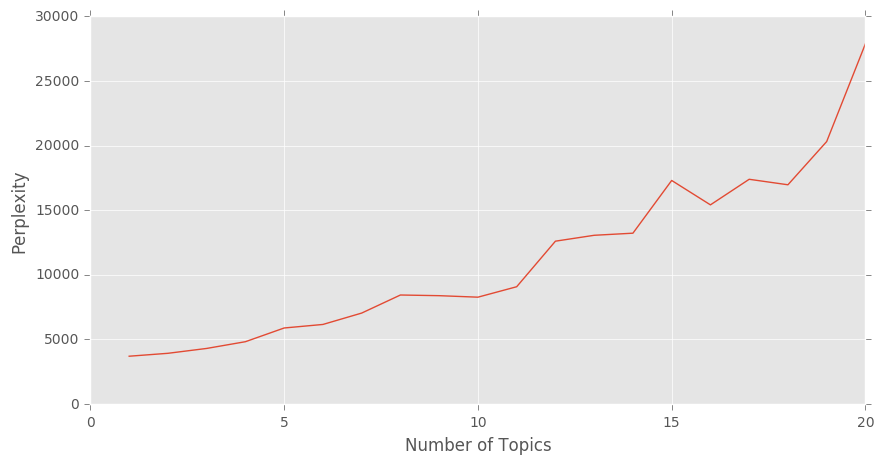

In [282]:
def choose_k(train_corp, dict_corp, test_text):
    #We will use the number of non zero entries divided by number of documents as a starting point for an upper bound 
    ub = dict_corp.num_nnz/dict_corp.num_docs

    perplex = []
    num_k = []

    #get corpus of the held out set to check for perplexity
    d_test = gensim.corpora.Dictionary(test_text)
    corpus_per = [d_test.doc2bow(text) for text in test_text]

    #we will enumerate until this number training an lda model with different values of k and get perplexity
    for k in range(1, ub):
        lda_k = model_lda(train_corp, dict_corp, k)
        num_k.append(k)
        per = lda_k.bound(corpus_per)
        per_word_perplex = np.exp2(-per / d_test.num_nnz)
        perplex.append(per_word_perplex)

    #used from homework 2 to adjust plot:
    matplotlib.use("svg")
    %matplotlib inline
    plt.style.use('ggplot')
    matplotlib.rcParams['figure.figsize'] = (10.0, 5.0) # you should adjust this to fit your screen

    x = num_k
    y = perplex        
    plt.xlabel("Number of Topics")
    plt.ylabel("Perplexity")
    plt.plot(x,y,'-')

#We will use the last set of data that used all processing
choose_k(c3, d3, test3)

In this case perplexity is lowest for lower topics. This seems to make sense given the amount of overlap.

## Example application: Amazon review topic detection

Now that you have some familiarity with LDA and the different choices, try to put it together with another example:
1. Scrape data
2. Complete processing to return a list of documents
3. Perform cross validation to select k using perplexity as a metric
4. Train the final model
5. Inspect topics

In [ ]:
#scrape reviews for Bottega Louie - this restaurant currently has over 13,000 reviews
#would like to see how more documents fair
rev_bl, h_bl = load_yelp('https://www.yelp.com/biz/bottega-louie-los-angeles')

In [ ]:
#process the data using all choices set
revproc_bl = processing(rev_bl, h_bl, 'text', stop=True, rare=True, stem=True, pos=True)
#build corpus on traiing data and split
dbl, cbl, trainbl, testbl = build_corpus(rp1)

In [ ]:
#plot for some values of k
choose_k(cbl, dbl, testbl):

In [ ]:
#run the model for chosen value of k
#replace 10 with manual inspection of data
k_bl=10
lda_bl = model_lda(cbl, dbl, k_bl)

## References and Further Reading
1. http://videolectures.net/sikdd2013_speh_dirichlet_allocation/
2. http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf
3. https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf
4. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4597325/
5. http://dl.acm.org.proxy.library.cmu.edu/citation.cfm?id=1639726
6. https://radimrehurek.com/gensim/models/ldamodel.html
7. http://jonathan-huang.org/research/dirichlet/dirichlet.pdf
8. http://cseweb.ucsd.edu/~dhu/docs/research_exam09.pdf
9. https://en.wikipedia.org/wiki/Dirichlet_distribution
10. https://en.wikipedia.org/wiki/Dirichlet_distribution